# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [ ]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')


### Define functions

In [59]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [61]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [62]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.head(n=30)
df

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70.00,Austria,3.75,Blend,Peru
1791,Zotter,Congo,749,2011,65.00,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65.00,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62.00,Austria,3.25,Blend,India


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [63]:
# YOUR CODE HERE

# Print cols and rows:
print(f"The dataset has {df.shape[1]} columns.")
print(f"The dataset has {df.shape[0]} rows.")

# Print col names:
print(50*'-')
print("The column names are:")
for col_name in df.columns:
    print(col_name)

print(50*'-')

# Print number of unique values for each col
print("The number of unique values in each column:")
for col_name in df.columns:
    print(f"Unique values in '{col_name}': {len(df[col_name].unique())}")
print(50*'-')

# Print unique 'cocoa_percent' values
print(f"'cocoa_percent' has {len(df.cocoa_percent.unique())} unique values.")

The dataset has 9 columns.
The dataset has 1795 rows.
--------------------------------------------------
The column names are:
maker
specific_origin
reference_number
review_date
cocoa_percent
maker_location
rating
bean_type
broad_origin
--------------------------------------------------
The number of unique values in each column:
Unique values in 'maker': 414
Unique values in 'specific_origin': 1038
Unique values in 'reference_number': 440
Unique values in 'review_date': 12
Unique values in 'cocoa_percent': 45
Unique values in 'maker_location': 58
Unique values in 'rating': 13
Unique values in 'bean_type': 39
Unique values in 'broad_origin': 160
--------------------------------------------------
'cocoa_percent' has 45 unique values.


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here: 

In [64]:
# YOUR CODE HERE

# After some exploration, I chose 
#   first to group maker location into 3 regions
#   North America, Western Europe, and the Rest of the World

# Then predict the maker region (1 out of the above 3)

# Print a summary of the data
print(f"A summary of the data: \n{df.info()}")
#print(df.maker_location.value_counts())

print(50*'-')

# Print out top maker location
print(df.maker_location.value_counts().sort_values(ascending=False).head(15))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   maker             1795 non-null   object 
 1   specific_origin   1795 non-null   object 
 2   reference_number  1795 non-null   int64  
 3   review_date       1795 non-null   int64  
 4   cocoa_percent     1795 non-null   float64
 5   maker_location    1795 non-null   object 
 6   rating            1795 non-null   float64
 7   bean_type         1795 non-null   object 
 8   broad_origin      1795 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB
A summary of the data: 
None
--------------------------------------------------
maker_location
U.S.A.         764
France         156
Canada         125
England         96
Italy           63
Ecuador         54
Australia       49
Belgium         40
Switzerland     38
Germany         35
Austria         26
Spain    

In [65]:
# Group maker locations into THREE groups

region_mapping = {
    # North America (Canada, USA, Mexico)
    'U.S.A.': 'North America',
    'Canada': 'North America',
    'Mexico': 'North America',

    # Western Europe (including Italy)
    'France': 'Western Europe',
    'Switzerland': 'Western Europe',
    'Netherlands': 'Western Europe',
    'Spain': 'Western Europe',
    'Italy': 'Western Europe',
    'Belgium': 'Western Europe',
    'Germany': 'Western Europe',
    'England': 'Western Europe',
    'Wales': 'Western Europe',
    'Scotland': 'Western Europe',
    'Portugal': 'Western Europe',
    'Denmark': 'Western Europe',
    'Sweden': 'Western Europe',
    'Austria': 'Western Europe',
    'Finland': 'Western Europe',
    'Iceland': 'Western Europe',
    'Ireland': 'Western Europe',

    # Rest of the World (All others)
    'Poland': 'Rest of the World',   # Central/Eastern Europe
    'Hungary': 'Rest of the World',  # Central Europe
    'Czech Republic': 'Rest of the World',
    'Lithuania': 'Rest of the World',  # Baltic region
    'Russia': 'Rest of the World',  # Eastern Europe
    'Costa Rica': 'Rest of the World',  # Central America
    'Puerto Rico': 'Rest of the World',
    'Honduras': 'Rest of the World',
    'Nicaragua': 'Rest of the World',
    'Guatemala': 'Rest of the World',
    'Dominican Republic': 'Rest of the World',
    'Fiji': 'Rest of the World',
    'Ecuador': 'Rest of the World',
    'Peru': 'Rest of the World',
    'Brazil': 'Rest of the World',
    'Venezuela': 'Rest of the World',
    'Colombia': 'Rest of the World',
    'Japan': 'Rest of the World',
    'New Zealand': 'Rest of the World',
    'South Korea': 'Rest of the World',
    'Martinique': 'Rest of the World',
    'Sao Tome': 'Rest of the World',
    'Argentina': 'Rest of the World',
    'South Africa': 'Rest of the World',
    'Bolivia': 'Rest of the World',
    'St. Lucia': 'Rest of the World',
    'Singapore': 'Rest of the World',
    'Vietnam': 'Rest of the World',
    'Grenada': 'Rest of the World',
    'Israel': 'Rest of the World',
    'India': 'Rest of the World',
    'Madagascar': 'Rest of the World',
    'Philippines': 'Rest of the World',
    'Chile': 'Rest of the World',
    'Ghana': 'Rest of the World',
    'Eucador': 'Rest of the World',  # Fixing typo for "Ecuador"
    'Suriname': 'Rest of the World'
}

# For make_loations that were not mapped, categorize them as the 'Rest of the World'.
df['maker_region'] = df['maker_location'].map(region_mapping).fillna('Rest of the World')

# Print out counts (after mapping/aggregation) for each of the classes (targets)
df.maker_region.value_counts()

maker_region
North America        893
Western Europe       530
Rest of the World    372
Name: count, dtype: int64

In [66]:
# Data processing for the prediction task 
# Encoding - first create dummies (bool)
df_encoded = pd.get_dummies(df, columns=['maker_region'])

# Change col names for class labels
df_encoded.rename(columns={
                            'maker_region_North America': 'north_america',
                            'maker_region_Western Europe': 'west_europe',
                            'maker_region_Rest of the World': 'rest_of_the_world'
                                },                  
                inplace=True)

# Define the cols that are class labels for convenience
outcome_cols = ['north_america', 'west_europe', 'rest_of_the_world']

# Cast class dummies (bool) to integers (0s and 1s)
df_encoded[outcome_cols] = df_encoded[outcome_cols].astype(int)

# Print out the head of the encoded data
df_encoded.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,north_america,rest_of_the_world,west_europe
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome,0,0,1
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,0,0,1
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,0,0,1
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0,0,1
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0,0,1


#### Ex 2 Comments

In this step, in choosing the prediction step, the following encoding is performed for features but it is done in a way that **no information leakage could happen**. It simply grouped categorical features and encoded into one-hot feature vectors. 

In [67]:
# Next group bean types from 39 to 3 groups
#   Then we have THREE 0-1 categorical variables for bean type
#   And drop one col to avoid perfect colinearity

# It makes more sense to do it here before the data processing step (before train-test split)

# Print out value counts
print(f"Original bean types: \n{df_encoded.bean_type.value_counts().head()}")

# Create mapping for bean type groups (3)
bean_type_mapping = {'Blend': 'Blend',
                     'Trinitario': 'Trinitario'}

#  Other than 'Blend' and 'Trinitario', 
#  the rest is swept under 'other'.
df_encoded['bean_type'] = df_encoded['bean_type'].map(bean_type_mapping).fillna('Other')

# After grouping:
print(50*'-')
print(f"After grouping, bean types: \n{df_encoded.bean_type.value_counts()}")

Original bean types: 
bean_type
Blend                   929
Trinitario              419
Criollo                 153
Forastero                87
Forastero (Nacional)     52
Name: count, dtype: int64
--------------------------------------------------
After grouping, bean types: 
bean_type
Blend         929
Other         447
Trinitario    419
Name: count, dtype: int64


In [68]:
# Now that we created a new bean type col, we need to create one-hot vectors and 
#   drop one col to avoid perfect colinearity

# First create dummies (bool)
df_encoded = pd.get_dummies(df_encoded, columns=['bean_type'])

# Then drop the bean type 'other' to avoid perfect colinearity 
df_encoded.columns[-1]
df_encoded.drop(columns='bean_type_Other', inplace=True)


# Create better col names
df_encoded.rename(columns={'bean_type_Blend': 'blend_bean',
                           'bean_type_Trinitario': 'trinitario_bean'},
                    inplace=True)

# Create a list of col names for convenience
bean_type_cols = ['blend_bean', 'trinitario_bean']

# Cast bean types from dummies (bool) to 0-1 integers
df_encoded[bean_type_cols] = df_encoded[bean_type_cols].astype(int)

# Take a look
print(f"After grouping and encoding bean type: \n{df_encoded.head()}")

After grouping and encoding bean type: 
      maker specific_origin  reference_number  review_date  cocoa_percent  \
0  A. Morin     Agua Grande              1876         2016          63.00   
1  A. Morin           Kpime              1676         2015          70.00   
2  A. Morin          Atsane              1676         2015          70.00   
3  A. Morin           Akata              1680         2015          70.00   
4  A. Morin          Quilla              1704         2015          70.00   

  maker_location  rating broad_origin  north_america  rest_of_the_world  \
0         France    3.75     Sao Tome              0                  0   
1         France    2.75         Togo              0                  0   
2         France    3.00         Togo              0                  0   
3         France    3.50         Togo              0                  0   
4         France    3.50         Peru              0                  0   

   west_europe  blend_bean  trinitario_bean  


---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [69]:
# YOUR CODE HERE

# Task 1: Shuffle

# Set seed
np.random.seed(19)

# Create indices
indices = np.arange(0, df.shape[0])

# Shuffle indices
shuffled_indices = np.random.permutation(indices)

# Shuffle the dataframe using the shuffled indices
df_encoded_shuffle = df_encoded.reindex(shuffled_indices)

# Print out the head of the shuffled data

print("Shuffled data") 
df_encoded_shuffle.head()

Shuffled data


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,broad_origin,north_america,rest_of_the_world,west_europe,blend_bean,trinitario_bean
1547,Soma,Black Science Blend 1,607,2010,70.00,Canada,3.75,"Dominican Republic,Ecuador,Peru",1,0,0,0,0
1409,Rozsavolgyi,Principe,765,2011,77.00,Hungary,2.75,Principe,0,1,0,0,0
1144,Molucca,Indonesia,1618,2015,70.00,U.S.A.,2.75,Indonesia,1,0,0,1,0
746,Guido Castagna,"Trinidad,Tobago",355,2009,64.00,Italy,3.00,"Trinidad,Tobago",0,0,1,1,0
401,Chocolate Conspiracy,Peru,1259,2014,74.00,U.S.A.,2.75,Peru,1,0,0,1,0


In [70]:
# Create X and Y

# Note that a list of target columns were defined earlier
X = df_encoded_shuffle.drop(columns=outcome_cols)
Y = df_encoded_shuffle[outcome_cols]

# Print out Y
print(f"Y head:\n{Y.head()}")

print(80*'-')

# print out X
print("X head:")
X.head()


Y head:
      north_america  west_europe  rest_of_the_world
1547              1            0                  0
1409              0            0                  1
1144              1            0                  0
746               0            1                  0
401               1            0                  0
--------------------------------------------------------------------------------
X head:


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,broad_origin,blend_bean,trinitario_bean
1547,Soma,Black Science Blend 1,607,2010,70.00,Canada,3.75,"Dominican Republic,Ecuador,Peru",0,0
1409,Rozsavolgyi,Principe,765,2011,77.00,Hungary,2.75,Principe,0,0
1144,Molucca,Indonesia,1618,2015,70.00,U.S.A.,2.75,Indonesia,1,0
746,Guido Castagna,"Trinidad,Tobago",355,2009,64.00,Italy,3.00,"Trinidad,Tobago",1,0
401,Chocolate Conspiracy,Peru,1259,2014,74.00,U.S.A.,2.75,Peru,1,0


In [71]:
# Task 2: Split the data into train, val, and test in 2 steps: 

# First to train-and-val and test
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2)

# Then split train-and-val into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25)

print('X_train shape:', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

print(50*'-')
print('Y_train shape:', Y_train.shape)
print('Y_val shape', Y_val.shape)
print('Y_test shape', Y_test.shape)

X_train shape: (1077, 10)
X_val shape (359, 10)
X_test shape (359, 10)
--------------------------------------------------
Y_train shape: (1077, 3)
Y_val shape (359, 3)
Y_test shape (359, 3)


In [72]:
# Task 3: Identify features of interest

# Features to keep
X_train = X_train[['cocoa_percent', 'rating', 'blend_bean', 'trinitario_bean']]

X_val = X_val[['cocoa_percent', 'rating', 'blend_bean', 'trinitario_bean']]
X_test = X_test[['cocoa_percent', 'rating', 'blend_bean', 'trinitario_bean']]



#### Ex 3 Comments and Answers
In choosing features:
 - Categorical variables that have a spread-out distribution and without an obvious meaningful grouping method were dropped.
    - For example, **broad_origin** have both locational and bean type entries.
    - **specific_region** and **maker** were also dropped due to this reason.

 - In a correlation EDA that was dropped from this final notebook, I found that numeric columns such as **review_date** and **reference_number** do not seem to correlate with other metric variables in any meaningful way, hence providing no (or very little) information for the prediction task. 

In [73]:
# Task 4: cleaning and standardization
# Note that some of the cleaning of the categorical variable was done in the last step (which makers more sense).

# Define a function to standardize data using training samples
# Max-Min scaling is chosen after exploring the data

def standardize(inputs, training_data):
    """  
    Return standardized max-min array 
    Args:
        inputs: a numpy array
        training_data: training data (features or outcome) used to calculate location and scale
    """
    return (inputs  - np.min(a=training_data, axis=0, keepdims=True)) / (np.max(a=training_data, axis=0, keepdims=True) - np.min(a=training_data, axis=0, keepdims=True))


# Cleaning: convert Pandas Series to numpy arrays
X_train = X_train.values
X_val = X_val.values 
X_test = X_test.values

Y_train = Y_train.values
Y_val = Y_val.values 
Y_test = Y_test.values

X_train_scaled = standardize(X_train, X_train)
X_val_scaled = standardize(X_val, X_train)
X_test_scaled = standardize(X_test, X_train)

print("Training features before standardization")
print(X_train)

print(50*"-")

print("Training features after standardization")
print(X_train_scaled)


Training features before standardization
[[70.    3.25  1.    0.  ]
 [55.    3.    1.    0.  ]
 [72.    2.75  1.    0.  ]
 ...
 [64.    3.    1.    0.  ]
 [75.    3.25  0.    1.  ]
 [72.    3.    0.    1.  ]]
--------------------------------------------------
Training features after standardization
[[0.48275862 0.75       1.         0.        ]
 [0.22413793 0.66666667 1.         0.        ]
 [0.51724138 0.58333333 1.         0.        ]
 ...
 [0.37931034 0.66666667 1.         0.        ]
 [0.56896552 0.75       0.         1.        ]
 [0.51724138 0.66666667 0.         1.        ]]


---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

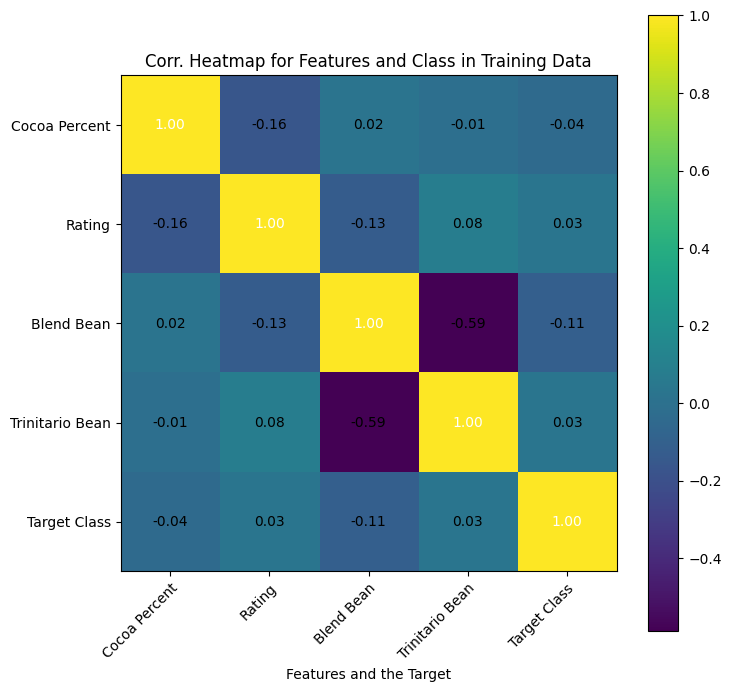

In [108]:

# I put my own imports where they are first called intentionally
from mlxtend.plotting import heatmap

# Create a 1-d np array indicating class
Y_train_labels = np.argmax(Y_train, axis=1)

# Calculate correlation between target and all features
cm = pd.concat([pd.DataFrame(X_train_scaled), pd.DataFrame(Y_train_labels)], axis=1).corr().values

# Plot 1: heatmap for correlations between features
fig, ax = heatmap(
    cm,
    row_names=['Cocoa Percent', 'Rating', 'Blend Bean', 'Trinitario Bean', 'Target Class'],
#    row_names=pd.DataFrame(X_train_scaled).columns,
    column_names=['Cocoa Percent', 'Rating', 'Blend Bean', 'Trinitario Bean', 'Target Class'],
#    column_names=pd.DataFrame(X_train_scaled).columns,
    figsize=(8, 8)
)
plt.xlabel('Features and the Target')
plt.title('Corr. Heatmap for Features and Class in Training Data')

plt.show()

# Please see comments in the markdown cell below

#### Heatmap Comments

 - Note that I dropped one of the three bean types ('other'), hence Blend Bean and Trinitario Bean are not perfectly correlated. 
 - Overall, correlations between features and target are weak. 
 - Importantly, note that **although we have 3 classes for maker region, thers *no* ordinal relationship among the 3 classes**.


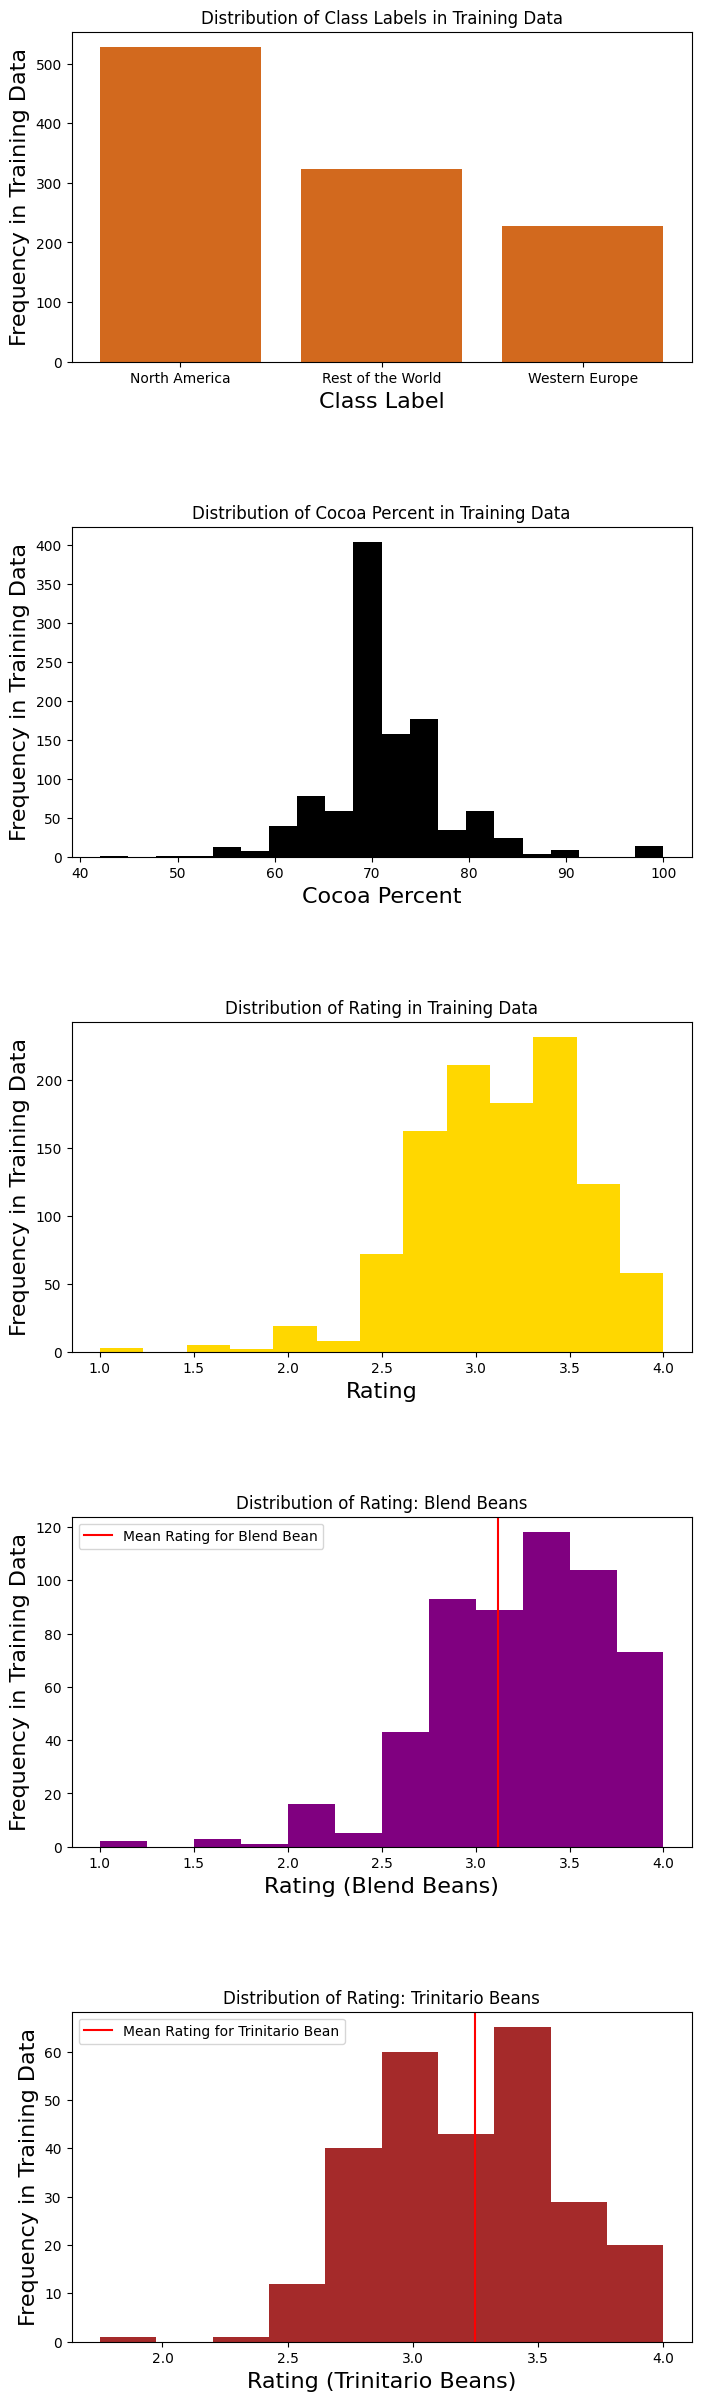

In [ ]:
# YOUR CODE HERE

Y_label_name = ['North America', 'Rest of the World', 'Western Europe']

maker_region_classes, counts = np.unique(Y_train_labels, return_counts=True)
fig, ax = plt.subplots(5, 1,
                       figsize=(8, 30))

ax[0].bar(maker_region_classes, counts, 
          tick_label=[f'{Y_label_name[i]}' for i in maker_region_classes],
          color='chocolate')
ax[0].set_title('Distribution of Class Labels in Training Data')
ax[0].set_xlabel('Class Label', fontsize=16)
ax[0].set_ylabel('Frequency in Training Data', fontsize=16)

ax[1].hist(X_train[:,0], 
           color='black',
           bins=20)
ax[1].set_title('Distribution of Cocoa Percent in Training Data')
ax[1].set_xlabel('Cocoa Percent', fontsize=16)
ax[1].set_ylabel('Frequency in Training Data', fontsize=16)

ax[2].hist(X_train[:,1], 
           color='gold',
           bins=13)
ax[2].set_title('Distribution of Rating in Training Data')
ax[2].set_xlabel('Rating', fontsize=16)
ax[2].set_ylabel('Frequency in Training Data', fontsize=16)

rating_blend = X_train[:, 1][X_train[:, 2] == 1]
rating_trinitario = X_train[:, 1][X_train[:, 3] == 1]

bean_types = ["Blend", "Trinitario"]

ax[3].hist(rating_blend,
           color='purple',
           bins=12)
ax[3].set_title('Distribution of Rating: Blend Beans')
ax[3].set_xlabel('Rating (Blend Beans)', fontsize=16)
ax[3].set_ylabel('Frequency in Training Data', fontsize=16)
ax[3].axvline(rating_blend.mean(),
              color='red',
              label='Mean Rating for Blend Bean')
ax[3].legend()

ax[4].hist(rating_trinitario,
           color='brown',
           bins=10)
ax[4].set_title('Distribution of Rating: Trinitario Beans')
ax[4].set_xlabel('Rating (Trinitario Beans)', fontsize=16)
ax[4].set_ylabel('Frequency in Training Data', fontsize=16)
ax[4].axvline(rating_trinitario.mean(),
              color='red',
              label='Mean Rating for Trinitario Bean')
ax[4].legend()


fig.subplots_adjust(hspace=0.5)	
plt.show()

#### Ex 4: EDA Comments Part 2

Above are visiualizations created from **training** data of mainly the distribution of features and targets. 
 - The distribution plots were created using before-standardization values for interpretability.
 - While North America makes up the majority of label class, the classes are not *too* imbalance. 
 - Cocoa percent distribution is somewhat symmetrical, but most cocoa percent are **between 60% and 80%**. 
 - Ratings are clustered between 2.5 and 5 with a thinner tail on the left.
 - The ratings for Blend Bean Chocolates distributed similarly to that of the Trinitario Bean Chocolates. **However, the last two distribution plots show that Blend Beans Chocolates are slightly *more popular* than Trinitario Chocolates**.

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [77]:
# YOUR CODE HERE

# Import libraries 
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
# Note that I implemented the log_loss manually, the above log_loss is used to verify my own log_loss.

# Task 1: implement the baseline model

# Define the baseline prediction function that gives constant probabilities based on label shares
def base_pred_prob(training_label):
    """  
    Return:
        An array (of the shape of one-hot training label) predicted probabilities 
        Probabilities are constant for each col representing the share in the training labels
      Output:
            probabilities array
    Args:
        Training labels in the one-hot format: shaped (number of example, number of labels).
    Note: 
        This function doesn't take in X_train
    """
    # np.ones() is used to broad cast the 1-d array to the shape of training labels
    return np.ones(training_label.shape) * (np.sum(training_label, axis=0) / np.sum(training_label)) 


# Define a function that returns labels.
#   This helps with readability for accuracy_score().
def to_label(input):
    """   
    Return:
        The position (label) that has the max value in a row for each line
    Args:
        An array
    """
    return np.argmax(input, axis=1)


#to_label(Y_train)

#to_label(base_pred_prob(Y_train))

base_accuracy = accuracy_score(to_label(Y_train), to_label(base_pred_prob(Y_train)))
print(50*'-')
print(f"Accuracy score of the baseline model: {base_accuracy:.3f}")


--------------------------------------------------
Accuracy score of the baseline model: 0.489


In [78]:
# Task 2: Log loss - manually implement, then verify using built-in function
# Log loss is calculated for both TRAIN and VAL


def manual_log_loss(label, pred):
    """  
    Return:
        Cross-entropy value 
    Args: 
        label: one-hot label (n-D array)
        pred: predicted proabiliteis (n-D array)
    """
    # We can do this because of np array broadcasting. Thank you, Assignment 0.
    return - np.sum(label * np.log(pred)) / label.shape[0]

# Calculate the log-loss for training data
print(f"Log-loss in training in baseline model: \n{manual_log_loss(Y_train, base_pred_prob(Y_train)):.3f}")

print(25*'*')
print(f"Log-loss in training in baseline model using sklearn built-in function: \n{log_loss(Y_train, base_pred_prob(Y_train)):.3f}")

print(50*'-')

print(f"Log-loss in validation in baseline model: \n{manual_log_loss(Y_val, base_pred_prob(Y_val)):.3f}")

print(25*'*')
print(f"Log-loss in validation in baseline model using sklearn built-in function: \n{log_loss(Y_val, base_pred_prob(Y_val)):.3f}")




Log-loss in training in baseline model: 
1.039
*************************
Log-loss in training in baseline model using sklearn built-in function: 
1.039
--------------------------------------------------
Log-loss in validation in baseline model: 
1.010
*************************
Log-loss in validation in baseline model using sklearn built-in function: 
1.010


### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

In [79]:
# YOUR CODE HERE

# Task 1: build and compile the Tensorflow model
# Since instruction did't say we can't add hidden layers, I added hidden layers in the following tf model
def build_model(num_features, learning_rate):
    """Build a TF multi-class logistic regression model using Keras.

    Args:
        num_features: The number of input features.
        learning_rate

    Returns:
        model: A tf.keras model (graph).
    """
    # Clear previous models and set a random seed
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build the model
    model = tf.keras.Sequential()


    # First Hidden Layer (128 nodes, ReLU activation)
    model.add(tf.keras.layers.Dense(
        units=128,                     # Number of neurons
        input_shape=(num_features,),   # Input shape (features)
        activation='relu',             # ReLU activation for hidden layers
        kernel_initializer='he_normal' # 
    ))

    # Second Hidden Layer (64 nodes)
    model.add(tf.keras.layers.Dense(
        units=64,
        activation='relu'
    ))

    # Output Layer (3 nodes for 3-class classification)
    model.add(tf.keras.layers.Dense(
        units=3,         
        activation='softmax'  # Multi-class classification
    ))

#   The following chunk is commented out but can be used to test a model without hidden layers
#   model.add(tf.keras.layers.Dense(
#       units=3,                   # Output dimension = number of classes (3)
#       input_shape=(num_features,),  # Input features
#       use_bias=True,               # Use bias term
#       activation='softmax',        # Multi-class classification
#       kernel_initializer='ones',  # Initialize weights to 1
#       bias_initializer='ones',    # Initialize bias to 1
#   ))

    # Use SGD optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',  # Multi-class classification loss
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


In [110]:
# YOUR CODE HERE

# Task 2: train the model

# Set seed
tf.random.set_seed(0)

# Build and compile model
model_tf = build_model(num_features=X_train_scaled.shape[1],
                       learning_rate=0.0001)

# Fit the model with specified hyperparameters
history = model_tf.fit(X_train_scaled, Y_train,
             epochs=10,
             batch_size=32,
             validation_data=(X_val_scaled, Y_val),
             verbose=1)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3134 - loss: 1.3577 - precision: 0.3211 - recall: 0.2320 - val_accuracy: 0.2813 - val_loss: 1.3748 - val_precision: 0.2943 - val_recall: 0.2173
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3046 - loss: 1.3279 - precision: 0.3177 - recall: 0.2251 - val_accuracy: 0.2702 - val_loss: 1.3437 - val_precision: 0.2950 - val_recall: 0.2145
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3071 - loss: 1.3010 - precision: 0.3110 - recall: 0.2168 - val_accuracy: 0.2702 - val_loss: 1.3152 - val_precision: 0.2955 - val_recall: 0.2033
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3098 - loss: 1.2764 - precision: 0.3090 - recall: 0.2088 - val_accuracy: 0.2786 - val_loss: 1.2897 - val_precision: 0.2888 - val_recall: 0.1866
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2988 - loss: 1.2541 - precision: 0.2866 - recall: 0.1768 - val_accuracy: 0.2786 - val_loss: 1.2662 - va

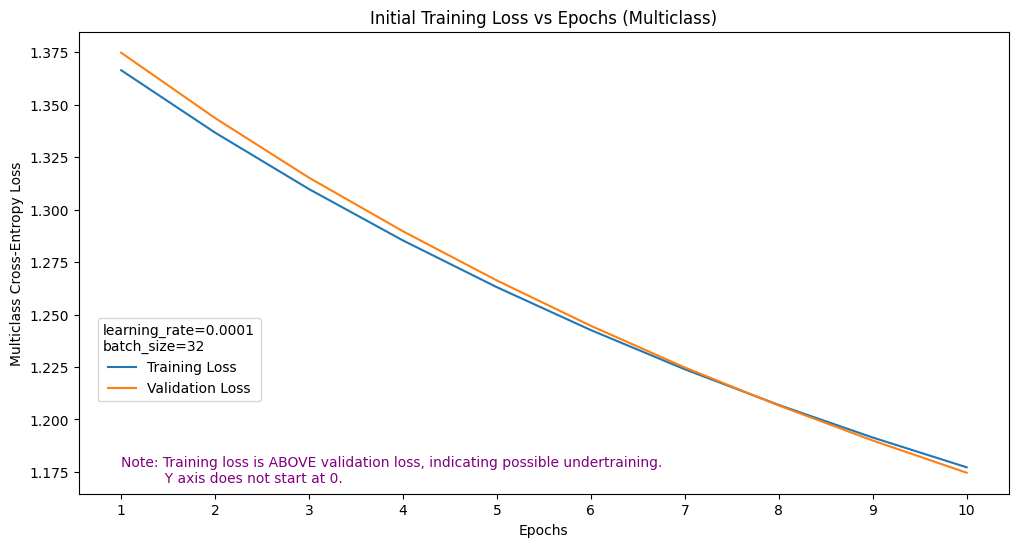

In [112]:
# Task 3: Plot loss of the untuned model: monitor train and val losses
fig, ax = plt.subplots(figsize=(12,6))

epochs = range(1, len(history.history['loss']) + 1)

ax.plot(epochs, history.history['loss'],
        label='Training Loss')
ax.plot(epochs, history.history['val_loss'],
        label="Validation Loss")

#plt.ylim(bottom=5.2)

ax.set_xlabel("Epochs")
ax.set_ylabel("Multiclass Cross-Entropy Loss")
ax.set_title("Initial Training Loss vs Epochs (Multiclass)")

plt.xticks(range(1, len(history.history['loss']) + 1, 1)) 
ax.legend(title='learning_rate=0.0001\nbatch_size=32', 
          loc=[0.02,0.20])


plt.text(1, 1.17, 
         "Note: Training loss is ABOVE validation loss, indicating possible undertraining.\n\
          Y axis does not start at 0.",
          fontsize=10, ha='left', color='purple')
plt.show()

---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). 

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

#### Note for Answers to Ex 7
 - learning rate and optimizer (not asked but tuned anyway) are tuned using tuner.
 - Batch size and the number of epochs are manually tuned. 

In [82]:
# YOUR CODE HERE

# I frist tune the model using Teras Tuner
# then provide answers and print-outs in the last code cell for this Exercise
# Import the turner API
import keras_tuner as kt

def build_tuned_model(hp, num_features):
    """Build a TF multi-class logistic regression model using Keras.

    Args:
        num_features: The number of input features.
        learning_rate

    Returns:
        model: A tf.keras model (graph).
    """
    # Clear previous models and set a random seed
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build the model
    model = tf.keras.Sequential()


    # First Hidden Layer (128 nodes, ReLU activation)
    model.add(tf.keras.layers.Dense(
        units=128,                     # Number of neurons
        input_shape=(num_features,),   # Input shape (features)
        activation='relu',             # ReLU activation for hidden layers
        kernel_initializer='he_normal'  
    ))

    # Second Hidden Layer (64 nodes)
    model.add(tf.keras.layers.Dense(
        units=64,
        activation='relu'
    ))

    # Output Layer (3 nodes for 3-class classification)
    model.add(tf.keras.layers.Dense(
        units=3,         
        activation='softmax'  # Multi-class classification
    ))

#   The following chunk is commented out but can be used to test a model without hidden layers
#   model.add(tf.keras.layers.Dense(
#       units=3,                   # Output dimension = number of classes (3)
#       input_shape=(num_features,),  # Input features
#       use_bias=True,               # Use bias term
#       activation='softmax',        # Multi-class classification
#       kernel_initializer='ones',  # Initialize weights to 1
#       bias_initializer='ones',    # Initialize bias to 1
#   ))

    # Tune optimizer
    optimizer_choice = hp.Choice("optimizer", ["SGD", "Adam"])

    # Tune learning rate
    learning_rate = hp.Choice("learning_rate", [1e-4, 1e-3, 1e-2, 1.e-1, 5.e-1])

    # Initialize chosen optimizer
    if optimizer_choice == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Compile model
    # Precision and recall are not asked by the exercise but kept for my own consumption
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model



In [83]:
# After re-building the model to be tuned
#   define tuner with Random Search

# TF tuner automatically saves results and since I also manually tuning the number of epochs and batch_size,
#   it works better to clear the saved search results when manually tuned hyperparameters were changed.
import shutil
shutil.rmtree("my_keras_tuner", ignore_errors=True)

tuner = kt.RandomSearch(
    lambda hp: build_tuned_model(hp, num_features=X_train_scaled.shape[1]),  
    objective="val_loss",  # Optimize for lowest validation cross-entropy loss
    max_trials=10,  
    executions_per_trial=1,
    directory="my_keras_tuner",
    project_name="tune_optimizer_lr_epochs"
)

# Search for optimal hyperprameters
tuner.search(X_train_scaled, Y_train, 
             validation_data=(X_val_scaled, Y_val),
             epochs=50,  
             batch_size=24,
             verbose=1)


Trial 10 Complete [00h 00m 11s]
val_loss: 1.017261266708374

Best val_loss So Far: 0.9749590158462524
Total elapsed time: 00h 01m 46s


In [84]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best optimizer: {best_hp.get('optimizer')}")
print(f"Best learning rate: {best_hp.get('learning_rate')}")

# Set epochs 
epochs = 50 

# Train final model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(X_train_scaled, Y_train,
                         epochs=epochs,
                         batch_size=24,
                         validation_data=(X_val_scaled, Y_val),
                         verbose=1)


Best optimizer: Adam
Best learning rate: 0.01
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4432 - loss: 1.1324 - precision: 0.5075 - recall: 0.3026 - val_accuracy: 0.5209 - val_loss: 0.9890 - val_precision: 0.6292 - val_recall: 0.3120
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5007 - loss: 1.0196 - precision: 0.5610 - recall: 0.2983 - val_accuracy: 0.5515 - val_loss: 0.9842 - val_precision: 0.6354 - val_recall: 0.3203
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5214 - loss: 1.0137 - precision: 0.5829 - recall: 0.2923 - val_accuracy: 0.5515 - val_loss: 0.9806 - val_precision: 0.6768 - val_recall: 0.3092
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5227 - loss: 1.0095 - precision: 0.5716 - recall: 0.3000 - val_accuracy: 0.5265 - val_loss: 0.9871 - val_precision: 0.6763 - val_recall: 0.2618
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5120 - loss: 1.0075 - precision: 0.5820 - recall: 0.3008 -

In [ ]:

# Task 2: the first five learned parameters (with hidden layers)
print("Note that there are hidden layers so I am printing from the first layer flattened")
print(f"The first five params: \n{best_model.get_weights()[0].flatten()[0:5]}")
print(50*'-')
print(f"The bias term params (last layer): \n{best_model.get_weights()[5]}")


# Task 3: loss at the final epoch - training and validation
print(80*"*")
print(f"Training loss at last epoch: {history.history['loss'][-1]:.3f}")
print(f"Validation loss at last epoch: {history.history['val_loss'][-1]:.3f}")


# Task 4: percentage different in train and val losses 
print(80*"*")
(history.history['loss'][-1] - history.history['val_loss'][-1]) / history.history['val_loss'][-1]
print(f"Percent diff between train loss and val loss \n- using val loss as denominator: {(history.history['loss'][-1] - history.history['val_loss'][-1]) / history.history['val_loss'][-1]:.2%}")
print('Negative value indicates trian loss smaller')

# Task 5: compare model_tf with baseline model
print(80*'*')
print(f"Baseline training loss: {log_loss(Y_train, base_pred_prob(Y_train)):.4f}")
print(f"Baseline validation loss: {log_loss(Y_val, base_pred_prob(Y_val)):.4f}")

print(50*'-')
print("Hence TensorFlow model improves a little over the baseline model on train dataset, \nbut does a little worse than the baseline model on validation dataset!")

Note that there are hidden layers so I am printing from the first layer flattened
The first five params: 
[ 0.37976977 -0.6571189  -0.45564216 -1.4352707   1.3149673 ]
--------------------------------------------------
The bias term params (last layer): 
[ 0.32874155 -0.06382658 -0.30917048]
********************************************************************************
Training loss at last epoch: 0.989
Validation loss at last epoch: 1.027
********************************************************************************
Percent diff between train loss and val loss 
- using val loss as denominator: -3.67%
Negative value indicates trian loss smaller
********************************************************************************
Baseline training loss: 1.0391
Baseline validation loss: 1.0099
--------------------------------------------------
Hence TensorFlow model improves a little over the baseline model on train dataset, 
but does little worse than the baseline model on validation dat

---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [92]:
# YOUR CODE HERE

# Calculate accuracy. 

# Becuase in standardization only two features of X were scaled and Y was not scaled, 
#   to predict, one should use X_train_scaled.
predicted_train_label = np.argmax(best_model.predict(X_train_scaled), axis=1)
true_train_label = np.argmax(Y_train, axis=1)

predicted_test_label = np.argmax(best_model.predict(X_test_scaled), axis=1)
true_test_label = np.argmax(Y_test, axis=1)

train_accu = accuracy_score(true_train_label, predicted_train_label)
test_accu = accuracy_score(true_test_label, predicted_test_label)

# I have verified that the following best_model.evaluate() returns the same accuracy scores.
#train_loss, train_accuracy, train_precision, train_recall = best_model.evaluate(X_train_scaled, Y_train, verbose=1)
#test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(X_test_scaled, Y_test, verbose=1)
#print(train_accuracy)
#print(test_accuracy)

print(f"Aggregate accuracy on train: {train_accu:.3f}")
print(f"Aggregate accuracy on test: {test_accu:.3f}")
print(50*"-")
print(50*'-')

# Recall that base_accuracy was calculated previously according to the next line:
#base_accuracy = accuracy_score(to_label(Y_train), to_label(base_pred_prob(Y_train)))

base_test_accuracy = accuracy_score(to_label(Y_test), to_label(base_pred_prob(Y_test)))

print(f"Accuracy score of the baseline model on train: {base_accuracy:.3f}")
print(f"Accuracy score of the baseline model on test: {base_test_accuracy:.3f}")

# Please see the markdown for comments

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Aggregate accuracy on train: 0.526
Aggregate accuracy on test: 0.529
--------------------------------------------------
--------------------------------------------------
Accuracy score of the baseline model on train: 0.489
Accuracy score of the baseline model on test: 0.499


#### Exercise 8 Answers and Comments

The Tensorflow model perform moderately better than the baseline model and hence have weak ability to generalize:
 - On train dataset, tf model's accuracy is 0.526 and baseline is 0.489.
 - On test dataset, ft model's accuracy is 0.529 and baseline is 0.499.

It is noteworthy that after adding hidden layers and hyperparameter tuning, the improvement is not big. This can indicate that the **selected features** have limited ability in predicting the maker regions as grouped above. It is also possible that the model archetecture could be further improved.

### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

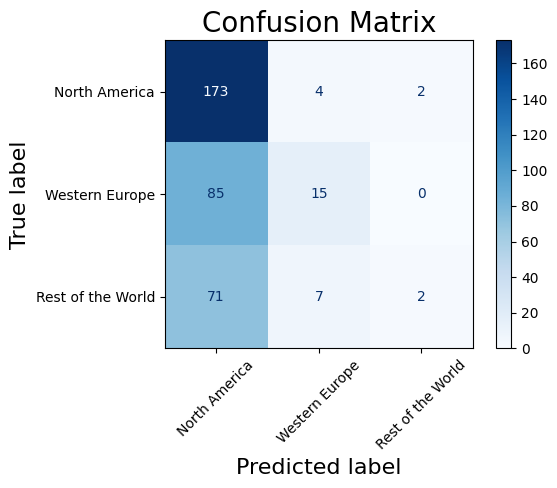

In [ ]:
# YOUR CODE HERE

# Importing the confusion matrix module
# Like before modules are imported where they are used intentionally
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = tf.math.confusion_matrix(
    true_test_label,
    predicted_test_label,
    num_classes=3,
    weights=None,
    name=None
)
# Visualization
# Convert the matrix entries to numpy arrays so that the ConfusionMatrixDisplay() would work
conf_matrix_np = conf_matrix.numpy() if isinstance(conf_matrix, tf.Tensor) else np.array(conf_matrix)

conf_matrix

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_np, display_labels=["North America", "Western Europe", "Rest of the World"])
#disp.plot(cmap="Blues")  # Customize color scheme

fig, ax = plt.subplots(figsize=(6, 4))

ax.set_xlabel("Predicted Label",
              fontsize=16)
ax.set_ylabel("Ture Label",
              fontsize=16)

disp.plot(cmap="Blues", ax=ax)


plt.xticks(rotation=45)  
plt.title("Confusion Matrix",
          fontsize=20)
plt.show()


# Precision and recall metrics are calculated in the next code cell

In [ ]:
recall_per_class = np.diag(conf_matrix_np) / np.sum(conf_matrix_np, axis=1)

# Compute precision per class (column-wise)
precision_per_class = np.diag(conf_matrix_np) / np.sum(conf_matrix_np, axis=0)

# Print results

# Recall that the class labels were assigned previously:
# outcome_cols = ['north_america', 'west_europe', 'rest_of_the_world']
#print(f"Recall per class: {recall_per_class}")
#f"{recall for recall in recall_per_class}"
for i in range(len(recall_per_class)):
    print(f"Recall for maker region {outcome_cols[i]}:\n {recall_per_class[i]:.2%}")

print(50*"-")

for i in range(len(precision_per_class)):
    print(f"Precision for maker region {outcome_cols[i]}:\n {precision_per_class[i]:.2%}")

print('')

Recall for maker region north_america:
 96.65%
Recall for maker region west_europe:
 15.00%
Recall for maker region rest_of_the_world:
 2.50%
--------------------------------------------------
Precision for maker region north_america:
 52.58%
Precision for maker region west_europe:
 57.69%
Precision for maker region rest_of_the_world:
 50.00%


#### Ex 9 Answers

Based on the above calculation and print outs:
 - Precision and false positives
    - The 3rd class, maker region 'Rest of the World' has the lowest precision, and the precision is 50% (= 2 / (2 + 2)). 
    - In terms of the absolute number of **false positives**, the first class (which has the highest precision) contributed 85 + 71 = 156 false positives. 
 - Recall and false negatives
    - The 3rd class, maker region 'Rest of the World' has the lowest recall, and the recall is 2.5% (= 2 / (71 + 7 + 2)).
    - In terms of the absolute number of **false negatives**, the 2nd class, 'Western Europe' contributed the most: 15. 


----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [33]:
# YOUR CODE HERE